<a href="https://colab.research.google.com/github/theJosephGoodman/AutoencodersOverview/blob/main/final_%5Bhw%5Dautoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Autoencoders


# Часть 1. Vanilla Autoencoder (10 баллов)

In [ ]:
!pip install GPUtil

  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=b8adeb6d30f2f4ef316380a396b0413ed542ebcdd7aaf3ee75dfaa071825a9bf
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built GPUtil


## 1.1. Подготовка данных (0.5 балла)


In [ ]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
%matplotlib inline


import os
import pandas as pd
import skimage

from sklearn.model_selection import train_test_split

from skimage import io
from skimage.transform import resize
from torchvision import transforms

from sklearn.manifold import TSNE
import seaborn as sns

from tqdm import tqdm_notebook
import gc
from GPUtil import showUtilization as gpu_usage

In [ ]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(DEVICE)

cuda


In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done



Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [ ]:
# <тут Ваш код>
data_train, data_val = train_test_split(data, train_size = 0.8, shuffle=True)

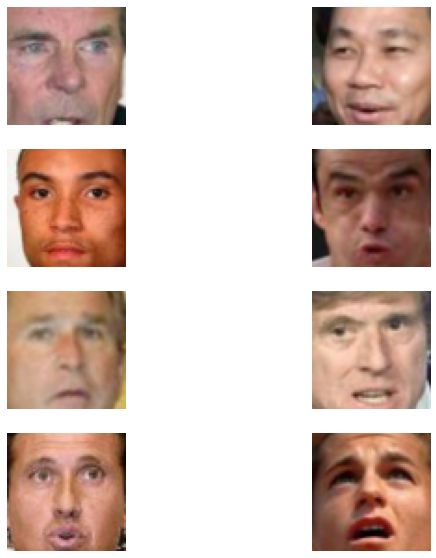

In [ ]:
# выведем несколько картинок
fig, ax = plt.subplots(4, 2, figsize = (10, 10))

for i, image in enumerate(ax.flatten()):
  image.imshow(data_train[i])
  image.axis('off')

## 1.2. Архитектура модели (1.5 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

In [ ]:
dim_features =256 # выберите размер латентного вектора

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [ ]:
dim_features = 256  # выберите размер латентного вектора
class Autoencoder(nn.Module):
    def __init__(self):
      super().__init__()
      self.encoder = nn.Sequential(
          nn.Conv2d(3, 32, 3, padding = 1), 
          nn.BatchNorm2d(32),
          nn.LeakyReLU(),

          nn.Conv2d(32, 32, 3, padding = 1),
          nn.BatchNorm2d(32),
          nn.LeakyReLU(),
          nn.MaxPool2d(kernel_size = 2, stride = 2), # 64->32

          nn.Conv2d(32, 64, 3, padding = 1),
          nn.BatchNorm2d(64),
          nn.LeakyReLU(0.01),

          nn.Conv2d(64, 64, 3, padding = 1),
          nn.BatchNorm2d(64),
          nn.LeakyReLU(0.01),
          nn.MaxPool2d(kernel_size = 2, stride = 2), # 32 -> 16

          nn.Conv2d(64, 64, 3, padding = 1),
          nn.BatchNorm2d(64),
          nn.LeakyReLU(0.01),

          nn.Conv2d(64, 64, 3, padding = 1),
          nn.BatchNorm2d(64),
          nn.LeakyReLU(0.01),
          nn.MaxPool2d(kernel_size = 2, stride = 2), # 16 -> 8

          nn.Flatten(),
          nn.Linear(8*8*64, dim_features))
      
      self.decoder = nn.Sequential(
          nn.Linear(dim_features, 8 * 8* 64),
          nn.Unflatten(1, (64, 8, 8)),
          nn.ConvTranspose2d(64, 64, stride = (2,2), kernel_size = 3, padding = 0),
          nn.BatchNorm2d(64),
          nn.LeakyReLU(0.01),
          nn.ConvTranspose2d(64, 32, stride = (2,2), kernel_size = 3, padding = 1),
          nn.BatchNorm2d(32),
          nn.LeakyReLU(0.01),
          nn.ConvTranspose2d(32, 3, stride = (2,2), kernel_size = 3, padding = 2, output_padding = 1),
          nn.Sigmoid()

      )      
      
        
    def forward(self, x):
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        # <реализуйте forward проход автоэнкодера
        # в качестве ваозвращаемых переменных -- латентное представление картинки (latent_code) 
        # и полученная реконструкция изображения (reconstruction)>
        
        return reconstruction, latent_code

In [ ]:
criterion = nn.BCELoss()

autoencoder = Autoencoder().to(DEVICE)

optimizer = optim.Adam(autoencoder.parameters()) #<Ваш любимый оптимизатор>
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 10, verbose=True)


Adjusting learning rate of group 0 to 1.0000e-03.


In [ ]:
# создаю даталоадеры
trainloader = torch.utils.data.DataLoader(torch.Tensor(data_train.swapaxes(1,3).swapaxes(2,3)), batch_size = 32, shuffle=True)
valloader = torch.utils.data.DataLoader(torch.Tensor(data_val.swapaxes(1,3).swapaxes(2,3)), batch_size = 32, shuffle=False)

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [ ]:
# <тут Ваш код тренировки автоэнкодера>
def train(model, loss_fn, optimizer, scheduler, data_tr, data_val, n_epochs = 20):
  losses = []


  for epoch in range(n_epochs):
      model.train()
      current_epoch_loss = 0
      print('')

      for X_batch in data_tr:
        optimizer.zero_grad()

        X_batch = X_batch.to(DEVICE)
        reconstruction, latent_space = model(X_batch)
        loss = loss_fn(reconstruction, X_batch )
        loss.backward()

        optimizer.step()
        current_epoch_loss += loss.cpu().item()

      avg_loss = current_epoch_loss/len(data_tr)
      print('Epoch: {}. Loss: {}'.format(epoch+1,avg_loss))
      losses.append(avg_loss)
      scheduler.step()
  return losses

In [ ]:
torch.cuda.empty_cache()
my_losses = train(autoencoder, criterion, optimizer, scheduler, data_tr=trainloader, data_val = valloader)
print(my_losses)


Epoch: 1. Loss: 0.626713477731838
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch: 2. Loss: 0.6078481712239854
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch: 3. Loss: 0.6038530535973314
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch: 4. Loss: 0.6023336458713451
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch: 5. Loss: 0.6014028651736065
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch: 6. Loss: 0.6007086562168272
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch: 7. Loss: 0.6000602768909605
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch: 8. Loss: 0.5996911960532237
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch: 9. Loss: 0.5993792753451501
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch: 10. Loss: 0.5990145929316257
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch: 11. Loss: 0.598271648934547
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch: 12. Loss: 0.598111926422293
Adjusting learning

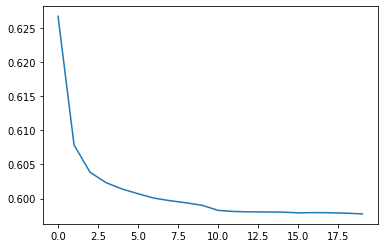

In [ ]:
plt.plot(my_losses)

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

In [ ]:
# < тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>
some_samples = next(iter(valloader))

autoencoder.eval()
with torch.no_grad():
  predictions, latent_space = autoencoder(some_samples.cuda())

In [ ]:
def to_imshow(x):
  return x.permute(0, 3, 2, 1).permute(0, 2, 1, 3).cpu().detach().numpy()

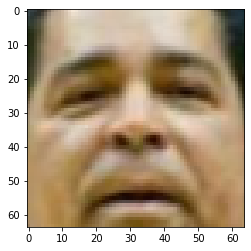

In [ ]:
plt.imshow(to_imshow(some_samples)[2])

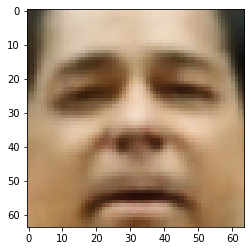

In [ ]:
plt.imshow(to_imshow(predictions)[2])

Not bad, right? 

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

In [ ]:
# сгенерируем 25 рандомных векторов размера latent_space
z = np.random.randn(25, dim_features)

autoencoder.eval()
with torch.no_grad():
  output = autoencoder.decoder(torch.Tensor(z).cuda()) 

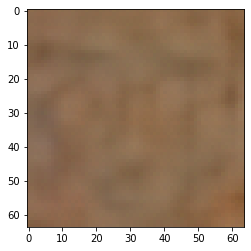

In [ ]:
# скорее всего латентное пространство слишком большой размерности и поэтому получается каша
plt.imshow(to_imshow(output)[10])

## Time to make fun! (4 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
# <ваш код здесь>
# здесь я заново загрузил датафрейм, потому что в изначальном не были указаны имена людей
people = pd.read_csv('lfw_attributes.txt', sep='\t', header=1)

# для большей точности вручную выбрал картинки, где один и тот же человек с улыбкой и без
smiling_indexes = [1984, 171, 308, 1433, 2593, 2816, 3722, 3843, 4623, 4810, 5046, 5071, 5448, 5497, 5619, 6220, 6468, 6842]
unsmiling_indexes = [1983, 170, 307, 1432, 2594, 2815, 3721, 3844, 4622, 4809, 5047, 5072, 5447, 5496, 5620, 6221, 6467, 6843]

# достаем необходимые образцы данных из data
smiling_data = data[smiling_indexes]
unsmiling_data = data[unsmiling_indexes]

# приводим к тензорам и меняем порядок осей
smiling_data = torch.Tensor(smiling_data.swapaxes(1,3).swapaxes(2,3))
unsmiling_data = torch.Tensor(unsmiling_data.swapaxes(1,3).swapaxes(2,3))

# получаем латентные представления улыбающихся и неулбающихся людей
autoencoder.eval()

with torch.no_grad():
  _, latent_smiling = autoencoder(smiling_data.cuda())
  _, latent_unsmiling = autoencoder(unsmiling_data.cuda())

# получаем "вектор улыбки"
smile_vector = latent_smiling.mean(dim = 0) - latent_unsmiling.mean(dim=0)

In [ ]:
# создаем функцию для удобного заставляния людей улыбаться
def make_smile(autoencoder, data, smile_vector=smile_vector):
  autoencoder.eval()
  with torch.no_grad():
    
    latent_space = autoencoder.encoder(data.cuda())
    latent_space += smile_vector
    reconstructed = autoencoder.decoder(latent_space).view(-1, 3, 64, 64)
    return reconstructed

In [ ]:
generated_data = make_smile(autoencoder, unsmiling_data.cuda(), smile_vector.cuda())

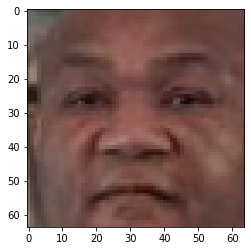

In [ ]:
plt.imshow(to_imshow(unsmiling_data)[7])

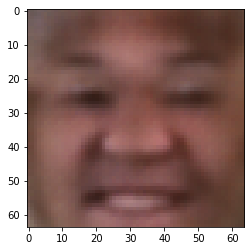

In [ ]:
plt.imshow(to_imshow(generated_data)[7])

Вуаля! Вы восхитительны!

In [ ]:
# блин, вы тоже!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

In [ ]:
# давай-ка теперь почистим наш ГПУ!
gpu_usage()

| ID | GPU | MEM |
------------------
|  0 |  0% |  8% |


In [ ]:
# опять какие-остатки остались :(
torch.cuda.empty_cache()
autoencoder.cpu()
del scheduler
del optimizer
del autoencoder
gc.collect()
torch.cuda.empty_cache()
gpu_usage()

| ID | GPU | MEM |
------------------
|  0 | 22% |  5% |


# Часть 2: Variational Autoencoder (10 баллов) 

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [ ]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=True)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [ ]:
dim_features = 7
class VAE(nn.Module):
    def __init__(self):
        # <определите архитектуры encoder и decoder
        # помните, у encoder должны быть два "хвоста", 
        # т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(10),
            nn.LeakyReLU(), 

            nn.Conv2d(10, 20, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(20),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2) ,#batch_size x 20 x 14 x 14

            nn.Conv2d(20, 40, kernel_size= 3, padding = 1),
            nn.BatchNorm2d(40),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2), # batch_size x 40 x 7 x 7 

            nn.Flatten(),

            nn.Linear(40 * 7 * 7, dim_features * 2)
            )
        self.decoder = nn.Sequential(
            nn.Linear(dim_features, 40 * 7 * 7),
            nn.Unflatten(1, (40, 7, 7)), # 7
            nn.Upsample(scale_factor=2), # 7 -> 14
            nn.BatchNorm2d(40),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(40, 20, kernel_size = 3, stride = 1, padding = 1), # 14 -> 14
            nn.BatchNorm2d(20),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(20, 1, kernel_size= 3, stride = 2, padding = 1, output_padding = 1),
            nn.Sigmoid()
        )
        

    def encode(self, x):
        # <реализуйте forward проход энкодера
        # в качестве ваозвращаемых переменных -- mu и logvar>
        x = self.encoder(x).view(-1, 2, dim_features)
        mu = x[:, 0, :]
        logvar = x[:, 1, :]
        return mu, logvar
    
    def gaussian_sampler(self, mu, logvar):
        if self.training:
            # <засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            z = mu + (eps * std)
            return z
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z):
        # <реализуйте forward проход декодера
        # в качестве возвращаемой переменной -- reconstruction>
        reconstruction = self.decoder(z)
        return reconstruction

    def forward(self, x):
        # <используя encode и decode, реализуйте forward проход автоэнкодера
        # в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        mu, logvar = self.encode(x)
        z = self.gaussian_sampler(mu, logvar)

        # decoding
        reconstruction = self.decode(z)
        return mu, logvar, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = - 0.5 * torch.sum(1 + logsigma - mu.pow(2) - torch.exp(logsigma)) #<напишите код для KL-дивергенции, пользуясь формулой выше>
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction = 'sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)  #<соедините тут две компоненты лосса. Mind the sign!>

In [ ]:
# переопределил немного функцию train

def train(model, loss_fn, optimizer, scheduler, data_tr, data_val, n_epochs = 20):
  losses = []


  for epoch in range(n_epochs):
      model.train()
      current_epoch_loss = 0
      print('')

      for X_batch, _ in data_tr:
        optimizer.zero_grad()

        X_batch = X_batch.to(DEVICE)
        mu_train, logvar_train, reconstruction = model(X_batch)
        loss = loss_fn(X_batch, mu_train, logvar_train, reconstruction)
        loss.backward()

        optimizer.step()
        current_epoch_loss += loss.cpu().item()

      avg_loss = current_epoch_loss/len(data_tr)
      print('Epoch: {}. Loss: {}'.format(epoch+1,avg_loss))
      losses.append(avg_loss)
      scheduler.step()
  return losses

И обучим модель:

In [ ]:
vae = VAE().to(DEVICE)

optimizer  = optim.Adam(vae.parameters())

scheduler = optim.lr_scheduler.StepLR(optimizer, 10)

loss = loss_vae

torch.cuda.empty_cache()
losses = train(vae, loss_fn=loss, optimizer = optimizer, scheduler = scheduler, data_tr = train_loader, data_val = None, n_epochs = 20)


Epoch: 1. Loss: 5168.558343098958

Epoch: 2. Loss: 3941.39103984375

Epoch: 3. Loss: 3830.943745052083

Epoch: 4. Loss: 3772.239634375

Epoch: 5. Loss: 3732.470512369792

Epoch: 6. Loss: 3703.65443203125

Epoch: 7. Loss: 3679.8759528645833

Epoch: 8. Loss: 3661.8513015625

Epoch: 9. Loss: 3646.7340162760415

Epoch: 10. Loss: 3633.076112109375

Epoch: 11. Loss: 3580.4946977864583

Epoch: 12. Loss: 3573.4316618489584

Epoch: 13. Loss: 3569.460944791667

Epoch: 14. Loss: 3567.335093098958

Epoch: 15. Loss: 3564.8438795572915

Epoch: 16. Loss: 3562.4712640625

Epoch: 17. Loss: 3561.917959765625

Epoch: 18. Loss: 3559.7224776041667

Epoch: 19. Loss: 3558.036335026042

Epoch: 20. Loss: 3557.02169375


Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

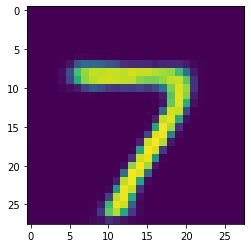

In [ ]:
# < тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>
tempbatch = next(iter(test_loader))[0]

vae.eval()

with torch.no_grad():
  _mu, _logvar, temp_generated = vae(tempbatch.cuda())

# берем 1 картинку из восстановленного батча
plt.imshow(temp_generated.cpu().detach().squeeze()[0])

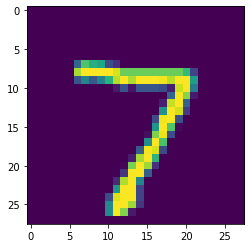

In [ ]:
# а вот изначальная семерочка
plt.imshow(tempbatch.cpu().detach().squeeze()[0])

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

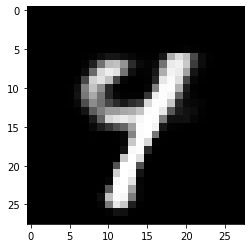

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных

# делаю батч из 10 случайных латентных векторов
z = np.array([np.random.normal(0, 1, dim_features) for i in range(10)])
with torch.no_grad():
  # генерирую данные из этих латентных векторов
  temp_generated = vae.decode(torch.Tensor(z).cuda())


# демонстрирую резултат работы
plt.imshow(temp_generated.cpu().detach().squeeze()[6], cmap='gray')

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве. 

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [ ]:
# <ваш код получения латентных представлений, применения TSNE и визуализации>
vae.eval()
latent_representation = []
i = 0
with torch.no_grad():
  for test_batch, _ in test_loader:
    mu, logvar = vae.encode(test_batch.cuda())
    z = vae.gaussian_sampler(mu, logvar)
    latent_representation.append(z.cpu().detach().numpy())
latent_representation = np.vstack(latent_representation)

In [ ]:
# а вот тут я натравил TSNE
# думаю его можно было и без нейросети использовать с картинками,
# но я так понимаю тут именно суть в том, чтобы показать, что в латентном представленни разные данные также разделяются на кластеры
tsne = TSNE()
pred = tsne.fit_transform(latent_representation)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


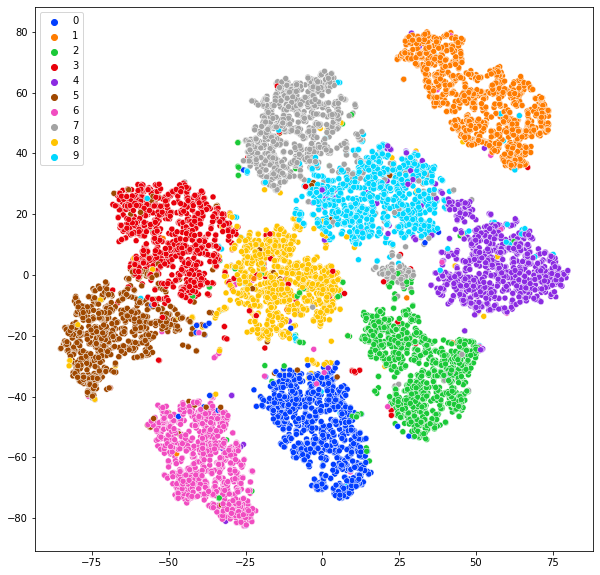

In [ ]:
# выводим картиночку
plt.figure(figsize = (10,10))
sns.scatterplot(pred[:, 0], pred[:, 1], hue = test_dataset.targets, palette=sns.color_palette('bright', 10))

Что вы думаете о виде латентного представления?

In [ ]:
# караул че за вид представления. Очень красиво смотрится
# шестерки, восьмерки и девятки вон ближе всего друг к другу
# и не даром, ведь они и без того похожи друг на друга

__Congrats v2.0!__

In [ ]:
# теперь снова чистм нашу ГПУшку
gpu_usage()

| ID | GPU | MEM |
------------------
|  0 |  4% |  5% |


In [ ]:
vae.cpu()

del scheduler
del optimizer
del vae

gc.collect()
torch.cuda.empty_cache()

In [ ]:
gpu_usage()

| ID | GPU | MEM |
------------------
|  0 |  0% |  5% |


## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [ ]:
dim_features = 7

class CVAE(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.encoder = nn.Sequential(
        nn.Linear(28*28 + 10, 300),
        nn.BatchNorm1d(300),
        nn.LeakyReLU(),

        nn.Linear(300, 150),
        nn.BatchNorm1d(150),
        nn.LeakyReLU(),

        nn.Linear(150, 50),
        nn.BatchNorm1d(50),
        nn.LeakyReLU(),

        nn.Linear(50, dim_features * 2)
    )
    self.decoder = nn.Sequential(
        nn.Linear(dim_features + 10, 50),
        nn.BatchNorm1d(50),
        nn.LeakyReLU(),

        nn.Linear(50, 150),
        nn.BatchNorm1d(150),
        nn.LeakyReLU(),

        nn.Linear(150, 300),
        nn.BatchNorm1d(300),
        nn.LeakyReLU(),

        nn.Linear(300, 28*28),
        nn.Unflatten(1, (1, 28,28)),

        nn.Sigmoid()
    )
  def encode(self, x, class_num):
    a = torch.flatten(x, start_dim = 1)

    a = torch.cat([a, class_num], dim = 1)
    z = self.encoder(a).view(-1, 2, dim_features)

    mu = z[:, 0, :]
    logsigma = z[:, 1, :]

    return mu, logsigma, class_num    

  def gaussian_sampler(self, mu, logsigma):
    if self.training:
      std = torch.exp(0.5 * logsigma)
      eps = torch.randn_like(std)
      z = mu + (std*eps)
      return z
    else:
      return mu
  def decode(self, z, class_num):
    reconstruction = self.decoder(torch.cat([z, class_num], dim = 1))
    return reconstruction

  def forward(self, x, class_num):
    mu, logsigma, class_num = self.encode(x, class_num)
    z = self.gaussian_sampler(mu, logsigma)

    reconstruction = self.decode(z, class_num)
    
    return mu, logsigma, reconstruction

In [ ]:
# снова переопределил функцию train
def train(model, loss_fn, optimizer, scheduler, data_tr, data_val = None, n_epochs = 20):
  losses = []

  for epoch in tqdm_notebook(range(n_epochs)):
    model.train()
    current_epoch_loss = 0
    print('')

    for x_batch, class_num in data_tr:
      optimizer.zero_grad()

      x_batch = x_batch.to(DEVICE)
      class_num = F.one_hot(class_num, 10)
      class_num  = class_num.to(DEVICE)

      mu_train, logsigma_train, reconstruction = model(x_batch, class_num)
      
      
      loss = loss_fn(x_batch, mu_train, logsigma_train, reconstruction)
      
      loss.backward()

      optimizer.step()

      current_epoch_loss += loss.cpu().item()

    avg_loss = current_epoch_loss/ len(data_tr)
    print('Epoch: {}. Loss: {}'.format(epoch+1, avg_loss))
    losses.append(avg_loss)
    scheduler.step()
  return losses
    
      

### Sampling


In [ ]:
# для начала обучим наш CVAE
cvae = CVAE().to(DEVICE)
optimizer = optim.Adam(cvae.parameters())

scheduler = optim.lr_scheduler.StepLR(optimizer, 10)
loss = loss_vae

torch.cuda.empty_cache()
losses = train(cvae, loss_fn=loss, optimizer = optimizer, scheduler = scheduler, data_tr = train_loader, data_val = None, n_epochs = 20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 1. Loss: 4489.3605670572915

Epoch: 2. Loss: 3943.4521407552083

Epoch: 3. Loss: 3828.272214583333

Epoch: 4. Loss: 3763.503844791667

Epoch: 5. Loss: 3720.911904947917

Epoch: 6. Loss: 3685.1557760416667

Epoch: 7. Loss: 3656.7792251302085

Epoch: 8. Loss: 3636.5946493489582

Epoch: 9. Loss: 3621.2742609375

Epoch: 10. Loss: 3607.2687944010418

Epoch: 11. Loss: 3523.768169921875

Epoch: 12. Loss: 3511.6326071614585

Epoch: 13. Loss: 3503.3426447916668

Epoch: 14. Loss: 3502.9122580729168

Epoch: 15. Loss: 3497.2119329427082

Epoch: 16. Loss: 3496.7020859375

Epoch: 17. Loss: 3492.7714196614584

Epoch: 18. Loss: 3491.5211848958334

Epoch: 19. Loss: 3488.335379166667

Epoch: 20. Loss: 3488.2505841145835


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

In [ ]:
# <тут нужно научиться сэмплировать из декодера цифры определенного класса>

cvae.eval()



indexes_for_onehot = torch.IntTensor([0, 1,2,3,4,5,6,7,8,9]).to(torch.int64)

with torch.no_grad():
  onehot_matrix = F.one_hot(indexes_for_onehot, 10)

  latent_vector = np.array([np.random.normal(0, 1, dim_features) for i in range(10)])
  temp_generated  = cvae.decode(torch.Tensor(latent_vector).cuda(), onehot_matrix.cuda()).cpu().detach().squeeze()

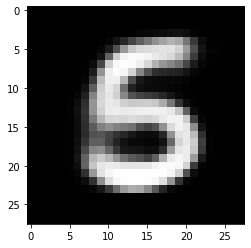

In [ ]:
plt.imshow(temp_generated[5], cmap='gray')

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
# <ваш код получения латентных представлений, применения TSNE и визуализации>

cvae.eval()
latent_representation = []
i = 0
with torch.no_grad():
  for test_batch, class_num in test_loader:
    class_num = F.one_hot(class_num, 10)

    mu, logvar, class_num_1 = cvae.encode(test_batch.cuda(), class_num.cuda())
    z = cvae.gaussian_sampler(mu, logvar)
    latent_representation.append(z.cpu().detach().numpy())
latent_representation = np.vstack(latent_representation)

In [ ]:
tsne = TSNE()
pred = tsne.fit_transform(latent_representation)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


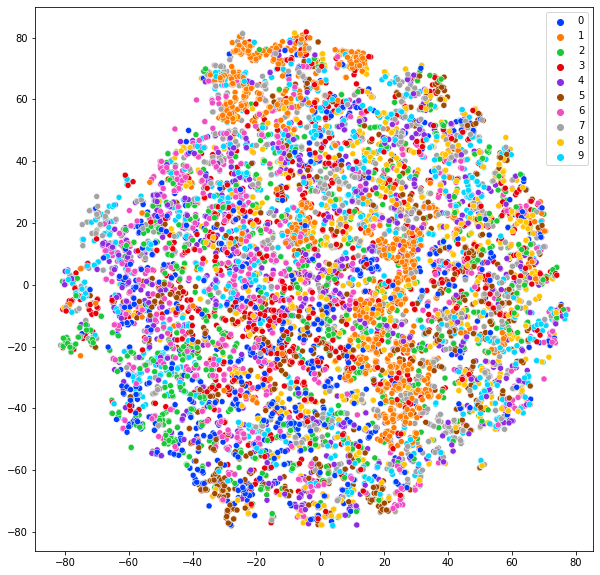

In [ ]:
# выводим картиночку
plt.figure(figsize = (10,10))
sns.scatterplot(pred[:, 0], pred[:, 1], hue = test_dataset.targets, palette=sns.color_palette('bright', 10))

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

In [ ]:
# че-то нифига не получилось с cvae :()

# BONUS 1: Denoising

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом. 

В питоне шум можно добавить так:

In [ ]:
noise_factor = 0.5
X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape) 

In [ ]:
<тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудтье разбить на train/test!>

In [ ]:
<тут проверка, как AE убирает щум с тестовых картинок. Надеюсь, все получилось =)>

# BONUS 2: Image Retrieval

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = <получение латентного представления image>
    
  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
<тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>